In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")


In [2]:
supply_data = pd.read_csv('./Datasets/Fact_Dimension_tables/FactTable.csv', encoding='ISO-8859-1', header=0)
supply_data.head()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Customer Id,Latitude,Longitude,order date (DateOrders),...,Cust_Country_Id,Cust_City_Id,Cust_Seg_Id,Pay_Type_Id,Dep_Id,Ord_Cty_Id,Ord_Ctry_Id,Ctg_Name_Id,Order Year,Order Month
0,3,4,91.250000,314.640015,Advance shipping,0,20755,18.251453,-66.037056,2018-01-31 22:56:00,...,0,0,0,0,0,0,0,0,2018,1
1,3,4,95.180000,262.200012,Advance shipping,0,16740,18.285494,-66.037056,2017-12-04 08:18:00,...,0,0,0,0,0,300,0,0,2017,12
2,2,1,65.550003,327.750000,Late delivery,1,16756,18.205177,-66.037064,2017-12-04 13:55:00,...,0,0,0,0,0,300,0,0,2017,12
3,2,1,87.610001,324.470001,Late delivery,1,16683,34.010460,-117.742088,2017-12-03 12:20:00,...,1,268,0,0,0,300,0,0,2017,12
4,2,1,18.440001,245.809998,Late delivery,1,16757,21.343153,-157.906601,2017-12-04 14:16:00,...,1,47,2,0,0,300,0,0,2017,12


In [3]:
# Columns overview
supply_data.columns

Index(['Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Customer Id', 'Latitude', 'Longitude',
       'order date (DateOrders)', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Product Name', 'Product Price',
       'Product Status', 'Market_Id', 'Del_Status_Id', 'Ship_Mode_id',
       'Cust_Country_Id', 'Cust_City_Id', 'Cust_Seg_Id', 'Pay_Type_Id',
       'Dep_Id', 'Ord_Cty_Id', 'Ord_Ctry_Id', 'Ctg_Name_Id', 'Order Year',
       'Order Month'],
      dtype='object')

In [4]:
# Choosen best features for predicting Sales based on analysing correlation plot
sales_data = supply_data[['order date (DateOrders)', 'Dep_Id', 'Order Item Discount Rate', 'Order Item Profit Ratio' ,'Order Item Quantity' , 'Sales']]
sales_data.head()

,order date (DateOrders),Dep_Id,Order Item Discount Rate,Order Item Profit Ratio,Order Item Quantity,Sales
0,2018-01-31 22:56:00,0,0.04,0.29,1,327.75
1,2017-12-04 08:18:00,0,0.20,0.36,1,327.75
2,2017-12-04 13:55:00,0,0.00,0.20,1,327.75
3,2017-12-03 12:20:00,0,0.01,0.27,1,327.75
4,2017-12-04 14:16:00,0,0.25,0.08,1,327.75


In [5]:
# Convert the 'order date (DateOrders)' column to datetime format
sales_data['order_date'] = pd.to_datetime(sales_data['order date (DateOrders)'])

# Extract year, week, and product name from the 'order_date' column
sales_data['year'] = sales_data['order_date'].dt.year
sales_data['week'] = sales_data['order_date'].dt.isocalendar().week
# Note: 'week' is deprecated, you may consider using 'weekofyear' instead
sales_data['Department_Id'] = sales_data['Dep_Id']

# Group by year, week, and product name and sum the sales
grouped_data = sales_data.groupby(['year', 'week', 'Department_Id']).agg({'Order Item Discount Rate': 'mean',
                                                                          'Order Item Profit Ratio': 'mean',
                                                                         'Order Item Quantity': 'sum',
                                                                         'Sales': 'sum'}).reset_index()

# Display the grouped data
print(grouped_data.head())

   year  week  Department_Id  Order Item Discount Rate  \
0  2015     1              0                  0.148000   
1  2015     1              1                  0.100934   
2  2015     1              2                  0.100152   
3  2015     1              3                  0.105588   
4  2015     1              4                  0.109487   

   Order Item Profit Ratio  Order Item Quantity         Sales  
0                 0.271000                   29    711.900001  
1                 0.090110                  383  28366.170964  
2                 0.064015                  383  17578.530093  
3                 0.164412                  184  16818.219917  
4                 0.162564                  123   3484.770006  


In [6]:
# Features selection for Training and Target variables
X = grouped_data.drop(['Sales'], axis=1)
y = grouped_data['Sales']

In [7]:
# filtering testing data based on dataset availabe on time interval roughly (20%)
# Create a mask for testing data (2017 and week 25 onwards)
train_mask = (grouped_data['year'] < 2017)

# Create a mask for testing data (20%)
test_mask = ~ train_mask

In [8]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = X[train_mask], X[test_mask], y[train_mask], y[test_mask]

In [9]:

# Define parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
}

# Create XGBoost model
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    reg_alpha=0.1,  # L1 regularization term (adjust as needed)
    reg_lambda=1.0,  # L2 regularization term (adjust as needed)
    random_state=42
)

# Converting X data into numpy array
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

# Apply log transformation to target variable to handle potential negative predictions
y_train_transformed = np.log1p(y_train)  # log(1 + y)
y_test_transformed = np.log1p(y_test)

# Perform grid search with cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_np, y_train_transformed)

# Print the best parameters
print("Best Hyperparameters:")
print(grid_search.best_params_)


Best Hyperparameters:
{'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 200}


In [12]:

# Initialize the XGBoost model with regularization and best parameters based on the grid search
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    reg_alpha=0.1,  # L1 regularization term (adjust as needed)
    reg_lambda=1.0,  # L2 regularization term (adjust as needed)
    learning_rate = 0.2,
    max_depth = 4,
    min_child_weight = 3,
    n_estimators = 200,
    random_state=42
)

# Apply log transformation to target variable to handle potential negative predictions
y_train_transformed = np.log1p(y_train)  # log(1 + y)
y_test_transformed = np.log1p(y_test)

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
# Train the model on the training set using 'fit' method
xgb_model.fit(X_train_np, y_train_transformed)

# Make predictions on the test set
y_pred_transformed = xgb_model.predict(X_test_np)
y_pred = np.expm1(y_pred_transformed)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")



Mean Squared Error (MSE): 889756660.1780835
R-squared: 0.5831236698175675
Mean Absolute Error (MAE): 9495.830984299628


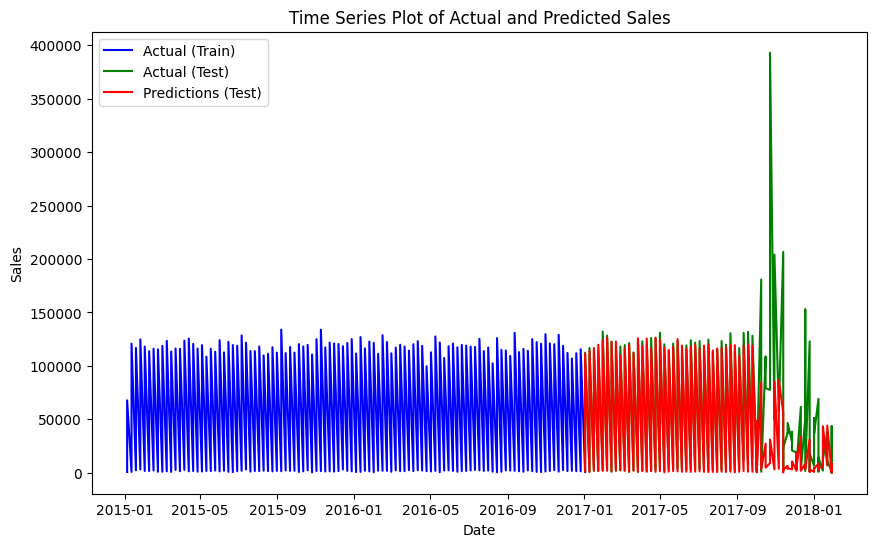

In [13]:
# Convert 'year' and 'week' to datetime index
grouped_data['Date'] = pd.to_datetime(grouped_data['year'].astype(str) + grouped_data['week'].astype(str) + '1', format='%Y%W%w')

# Plot actual values and predictions
plt.figure(figsize=(10, 6))
plt.plot(grouped_data['Date'][train_mask], y_train, label='Actual (Train)', color='blue')
plt.plot(grouped_data['Date'][test_mask], y_test, label='Actual (Test)', color='green')
plt.plot(grouped_data['Date'][test_mask], y_pred, label='Predictions (Test)', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Time Series Plot of Actual and Predicted Sales')
plt.legend()
plt.show()